In [1]:
import cv2
import os
import sys
import numpy as np
import math
import matplotlib.pyplot as plt

rtDirectory = '/Users/ejbeazleigh/Downloads/ImageProcessing/WeedData'
train = []
labels = []
for weed in os.listdir(os.path.join(rtDirectory, 'train')):
    print(weed)
    if os.path.isdir(os.path.join(rtDirectory, 'train', weed)):
        for img in os.listdir(os.path.join(rtDirectory, 'train', weed)):
            if img.endswith(".jpg") or img.endswith(".png"):  # Adjust the file extensions as per your image types
                train.append(cv2.imread(os.path.join(rtDirectory, 'train', weed, img)))
                labels.append(weed)
new_size = (236, 236)



cleavers
.DS_Store
charlock


In [6]:
########## pre processing 2 - contrast enhancement 
def power_law_transform(img, c, gamma):
    # convert BGR img to gray level
    gray =  cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # apply power-law function
    gray = c*(gray**gamma)
    # convert gray level range to [0,255]
    gray = (255/(gray.max()-gray.min())*(gray - gray.min())).astype(np.uint8)
    # convert gray level img to BGR
    img = cv2.cvtColor(gray,cv2.COLOR_GRAY2BGR)
    return img
####### pre processing 3 - noise reduction 
resizeNnoisereduction = []
for img in train:
    img = cv2.resize(img,new_size)
    img = cv2.fastNlMeansDenoising(img)
    resizeNnoisereduction.append(img)
ProcessedImages = []
for img in resizeNnoisereduction:
    img = power_law_transform(img,1,0.5)
    ProcessedImages.append(img)

In [13]:
test = []
testlabels = []
for weed in os.listdir(os.path.join(rtDirectory, 'test')):
    print(weed)
    if os.path.isdir(os.path.join(rtDirectory, 'test', weed)):
        for img in os.listdir(os.path.join(rtDirectory, 'test', weed)):
            if img.endswith(".jpg") or img.endswith(".png"):  # Adjust the file extensions as per your image types
                test.append(cv2.imread(os.path.join(rtDirectory, 'test', weed, img)))
                testlabels.append(weed)

def processfunc(img):
    processingfunc = []
    for i in img:
        img = cv2.resize(i, (236, 236))
        img = cv2.fastNlMeansDenoising(img)
        processingfunc.append(img)
    return processingfunc 

test = processfunc(test)




cleavers
.DS_Store
charlock


In [14]:
#OPTION 3 Haris Corner Detecion +Hyperparamter tuning 
# Feature extraction using Harris corner detection
def harris_corner_detection(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = np.float32(gray)
    corners = cv2.cornerHarris(gray, 2, 3, 0.04)
    corners = cv2.dilate(corners, None)
    img[corners > 0.01 * corners.max()] = [0, 0, 255]
    return img
HarrisTrainVals = []
for img in train:
    img_harris = harris_corner_detection(img)
    harris_vals = np.mean(np.array(img_harris), axis=(0, 1))
    HarrisTrainVals.append(harris_vals)
# Convert lists to numpy arrays
X_train_harris = np.array(HarrisTrainVals)
HarrisTestVals = []
for img in test:
    img_harris = harris_corner_detection(img)
    harris_vals = np.mean(np.array(img_harris), axis=(0, 1))
    HarrisTestVals.append(harris_vals)
# Convert lists to numpy arrays
X_test_harris = np.array(HarrisTestVals)
# Concatenate the Harris corner detection features
X_train = X_train_harris
X_test = X_test_harris
# Check the dimension of X_train and X_test after feature concatenation
print(X_train.shape, X_test.shape)



(480, 3) (158, 3)


In [16]:
# Define the target labels for the training set
y_train = []
for weed in os.listdir(os.path.join(rtDirectory, 'train')):
    if os.path.isdir(os.path.join(rtDirectory, 'train', weed)):
        for img in os.listdir(os.path.join(rtDirectory, 'train', weed)):
            if img.endswith(".jpg") or img.endswith(".png"):
                y_train.append(weed)

# Convert the list to a numpy array
y_train = np.array(y_train)


# Define the target labels for the test set
y_test = []
for weed in os.listdir(os.path.join(rtDirectory, 'test')):
    if os.path.isdir(os.path.join(rtDirectory, 'test', weed)):
        for img in os.listdir(os.path.join(rtDirectory, 'test', weed)):
            if img.endswith(".jpg") or img.endswith(".png"):
                y_test.append(weed)

# Convert the list to a numpy array
y_test = np.array(y_test)

In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
#############OPTION 3 HCD +HYPERPARAMTER TUNING ##############
# Define the hyperparameters and their respective values to search over
parameters = {'C': [0.1, 1, 10],'penalty': ['l1', 'l2'],'solver': ['liblinear'],'max_iter': [500, 1000, 2000]}
# Create an instance of the Logistic Regression model
logistic_regression = LogisticRegression()
# Create a GridSearchCV object
grid_search = GridSearchCV(logistic_regression, parameters, scoring='accuracy')
# Fit the GridSearchCV object to the training data
grid_search.fit(X_train_harris, y_train)
# Access the best hyperparameters and the best estimator
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_
# Use the best estimator to make predictions on the test data
y_pred = best_estimator.predict(X_test_harris)
# Evaluate the performance of the best estimator
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)
# Print the best hyperparameters
print("Best Hyperparameters:", best_params)


Test Accuracy: 0.759493670886076
Best Hyperparameters: {'C': 1, 'max_iter': 500, 'penalty': 'l1', 'solver': 'liblinear'}


Training Accuracy: 0.7395833333333334
Test Accuracy: 0.7531645569620253
F1-score: 0.7368398411254576
Precision: 0.7820744656187695
Recall: 0.7531645569620253


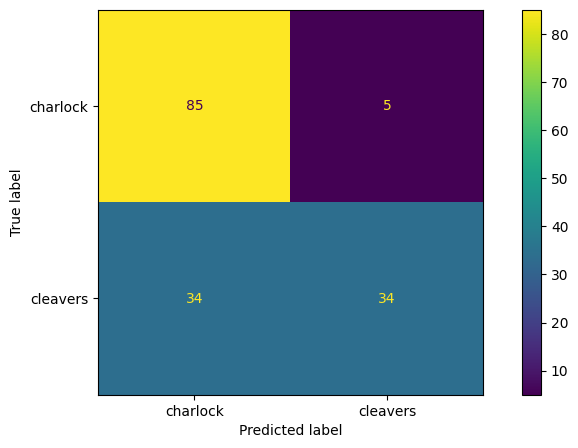

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
#########################OPTION 3 HCD  +HYPERTUNING ##########################
# Create a new instance of LogisticRegression with the best hyperparameters
best_params = {'C': 10, 'max_iter': 500, 'penalty': 'l1', 'solver': 'liblinear'}
clf = LogisticRegression(**best_params)
# Fit the model to the training data
clf.fit(X_train, y_train)
# Model evaluation on training data
train_accuracy = clf.score(X_train, y_train)
print("Training Accuracy:", train_accuracy)
# Predict the labels in the test dataset
y_test_predict = clf.predict(X_test)
# Overall Accuracy
test_accuracy = accuracy_score(y_test, y_test_predict)
print("Test Accuracy:", test_accuracy)
# F1-score
f1 = f1_score(y_test, y_test_predict, average='weighted')
print("F1-score:", f1)
# Precision
precision = precision_score(y_test, y_test_predict, average='weighted')
print("Precision:", precision)
# Recall
recall = recall_score(y_test, y_test_predict, average='weighted')
print("Recall:", recall)
# Confusion Matrix
cm = confusion_matrix(y_test, y_test_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
fig, ax = plt.subplots(figsize=(10, 5))
disp.plot(ax=ax)
plt.show()